In [230]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from encoder.digit_encoder import small_int_vector_asimage
from sparse_causal_model_learner_rl.trainable.combined import FCCombinedModel
from sparse_causal_model_learner_rl.loss.losses import manual_switch_gradient
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, LearnableSwitchSimple
import seaborn as sns
from functools import partial
from tqdm.auto import tqdm
from causal_util.helpers import lstdct2dctlst
from math import ceil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


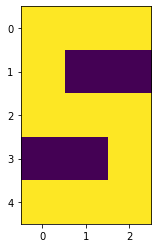

In [7]:
plt.imshow(small_int_vector_asimage([5]))

In [74]:
features = torch.arange(5)
obs = torch.from_numpy(np.array([small_int_vector_asimage([int(t)]) for t in features], dtype=np.float32)).cuda().detach()

In [81]:
obs_next = obs[torch.randperm(len(obs))]

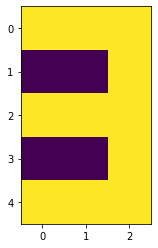

In [82]:
plt.imshow(obs_next[0].detach().cpu().numpy())

In [77]:
obs_std = obs.std(0, keepdim=True)

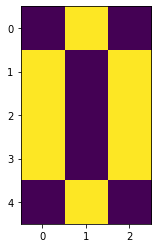

In [80]:
plt.imshow(obs[0].detach().cpu().numpy())

In [83]:
shape = obs.shape[1:]
size = np.prod(shape)
print(shape, size)
n_f = 10

torch.Size([5, 3]) 15


In [217]:
dec = FCCombinedModel(input_reshape=True,
                      add_input_batchnorm=True,
                      input_shape=(size,),
                      output_shape=(n_f,),
                      hidden_sizes=[50],
                      activation_cls=nn.LeakyReLU).cuda()
rec = FCCombinedModel(input_reshape=True,
                      input_shape=(n_f,),
                      output_shape=(size,),
                      add_input_batchnorm=True,
                      hidden_sizes=[50],
                      activation_cls=nn.LeakyReLU).cuda()
model = WithInputSwitch(model_cls=partial(FCCombinedModel,
                                          output_shape=(1,),
                                          add_input_batchnorm=True,
                                          hidden_sizes=[10],
                                          activation_cls=nn.LeakyReLU),
                        input_shape=(n_f,),
                        switch_cls=LearnableSwitchSimple,
                        give_mask=True,
                        n_models=n_f).cuda()

class MM():
    def __init__(self, model):
        self.model = model

[False, False]
[15, 50, 1] 10
[False, False]
[10, 50, 1] 15
[False, False]
[20, 10, 1] 10


In [218]:
(rec(dec(obs.flatten(start_dim=1))).view(obs.shape[0], *shape) - obs).flatten(start_dim=1).pow(2).sum(1).mean(0)

tensor(10.1514, device='cuda:0', grad_fn=<MeanBackward1>)

In [239]:
def tensor_std(t, eps=1e-8):
    s = t.std(0, keepdim=True)
    s = torch.where(s < eps, torch.ones_like(s), s)
    return s

def rec_loss_std(obs, obs_rec, nomean=False):
    delta = (obs - obs_rec)
    delta = delta / obs_std
    loss = delta.flatten(start_dim=1).pow(2).sum(1)
    if not nomean:
        loss = loss.mean(0)
    return loss

def acc_one(obs, obs_rec):
    acc = (((obs > 0.5) == (obs_rec > 0.5)) * 1.0).flatten(start_dim=1).mean()
    return acc

def rec_loss():
    f_pred = dec(obs.flatten(start_dim=1))
    obs_rec = rec(f_pred).view(obs.shape[0], *shape)
    loss = rec_loss_std(obs, obs_rec)
    acc = acc_one(obs, obs_rec)
    return {'loss': loss, 'metrics': {'acc': acc.item()}}

def fit_loss(force_proba=None, fill_switch_grad=False):
    f_curr = dec(obs.flatten(start_dim=1))
    f_next = dec(obs_next.flatten(start_dim=1))
    
    f_pred = model(f_curr, force_proba=force_proba)
    obs_next_pred = rec(f_pred).view(obs.shape[0], *shape)
    
    delta_f = (f_next - f_pred)
    std_f = tensor_std(f_curr)    
    delta_f = delta_f / std_f
    
    loss_fcons = delta_f.pow(2).sum(1)
    
    loss = rec_loss_std(obs_next, obs_next_pred, nomean=True)
    acc = acc_one(obs_next, obs_next_pred)
    
    loss_total = loss + loss_fcons
    
    if fill_switch_grad:
        manual_switch_gradient(loss_delta_noreduce=loss_total, model=model)
    
    loss_total = loss_total.mean(0)
    
    return {
        'loss': loss_total,
        'metrics': {
            'rec': loss.mean(0).item(),
            'fcons': loss_fcons.mean(0).item(),
            'acc': acc.item()
    }}

def sparsity_loss():
    t = list(model.switch.parameters())[0]
    return {'loss': t.abs().sum(), 'metrics': {}}

def total_loss(coeffs=None):
    if coeffs is None:
        coeffs = {}
    
    metrics = {}
    
    losses = {'rec': rec_loss,
              'fit': partial(fit_loss, fill_switch_grad=True),
              'fit_half': partial(fit_loss, force_proba=0.5),
              'fit_all': partial(fit_loss, force_proba=1.0),
              'sparsity': sparsity_loss
              }
    
    total_loss = 0.0
    
    for key, fcn in losses.items():
        data = fcn()
        coef = coeffs.get(key, 1.0)
        total_loss += data['loss'] * coef
        for m_key, m_val in data['metrics'].items():
            metrics[f'{key}/{m_key}'] = m_val
        metrics[f'{key}/loss'] = data['loss'].item()
            
    return total_loss, metrics

In [240]:
crit_ratio = 1.5
sp_min = 1e-9
sp_max = 100
coeffs = {'rec': 10.0, 'fit': 0.5, 'fit_half': 0.01, 'fit_all': 0.5, 'sparsity': sp_min}

In [241]:
metrics_hist = []

In [242]:
rec_loss(), fit_loss(), fit_loss(force_proba=0.5), fit_loss(force_proba=1.0), sparsity_loss()

({'loss': tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'acc': 1.0}},
 {'loss': tensor(3.2126, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 0.2380010336637497,
   'fcons': 2.9745657444000244,
   'acc': 1.0}},
 {'loss': tensor(3.2272, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 0.19248171150684357,
   'fcons': 3.034722089767456,
   'acc': 1.0}},
 {'loss': tensor(0.2408, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 0.007014110684394836,
   'fcons': 0.23376531898975372,
   'acc': 1.0}},
 {'loss': tensor(8.0672, device='cuda:0', grad_fn=<SumBackward0>),
  'metrics': {}})

In [243]:
opt = torch.optim.Adam(list(dec.parameters()) + list(rec.parameters()) + list(model.parameters()),
                       lr=1e-3)

In [244]:
for i in tqdm(range(1000)):
    opt.zero_grad()
    loss, metrics = total_loss({'sparsity': 1.0})
    loss.backward()
    opt.step()

    ratio = metrics['fit/loss'] / metrics['fit_all/loss']

    coeff = coeffs['sparsity']
    if ratio >= crit_ratio:
        coeff *= 0.5
    elif ratio < crit_ratio:
        coeff /= 0.5
    if coeff < sp_min:
        coeff = sp_min
    elif coeff > sp_max:
        coeff = sp_max

    metrics['coeff'] = coeff
    metrics['ratio'] = ratio
    metrics['total_loss'] = loss.item()

    metrics_hist.append(metrics)

AttributeError: 'FCCombinedModel' object has no attribute 'last_mask'
  In call to configurable 'manual_switch_gradient' (<function manual_switch_gradient at 0x7f6dfd7fad40>)

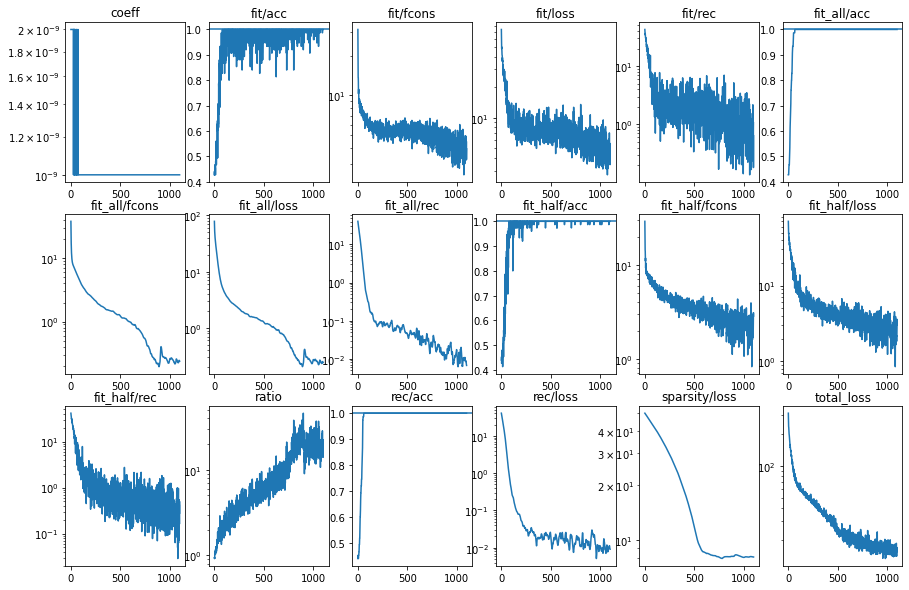

In [228]:
metrics_dict = lstdct2dctlst(metrics_hist)

keys = sorted(metrics_dict.keys())

px = 3
py = 6
assert px * py >= len(keys)

plt.figure(figsize=(15, 10))
for i, key in enumerate(keys, 1):
    plt.subplot(px, py, i)
    plt.title(key)
    plt.plot(metrics_dict[key])
    if key.endswith('acc'):
        plt.axhline(1)
    else:
        plt.yscale('log')
plt.show()

<AxesSubplot:>

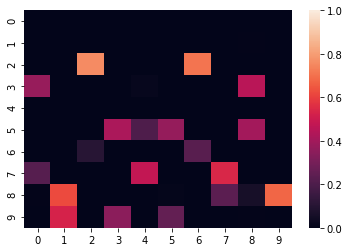

In [229]:
sns.heatmap(model.switch.probas.detach().cpu().numpy(), vmin=0, vmax=1)